## Choosing hyperparameters for GAiA's neural network

In this notebook, we are trying different numbers of SE-ResNet blocks for our final model.

In [1]:
import sys
sys.path.insert(1, "lib/")
sys.path.insert(1, "model/")
from GAiA_network import GAiA_Network, coeff_determination
from dataset_utils import read_many_hdf5, board_shape, encode_position, decode_position

import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

import platform
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

if tf.test.gpu_device_name(): 
  print(f"Default GPU Device: {tf.test.gpu_device_name()}")

Default GPU Device: /device:GPU:0


2021-11-26 08:03:18.802005: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-26 08:03:18.850511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 08:03:18.954382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 08:03:18.954623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

We are loading our training dataset and we are using it to build different training and validation data
for each model.

In [2]:
directory = "/media/gaetan/HDD/IA/Chess/Datasets/SE_ResNet/"
positions, scores = read_many_hdf5(497764, directory, "_train")
positions = positions[:250000]
scores = scores[:250000]

nb_models = 5
positions_train, scores_train = [], []
positions_valid, scores_valid = [], []
for i in range(nb_models):
  positions_train_t, positions_valid_t, scores_train_t, scores_valid_t = train_test_split(
    positions, scores, test_size=0.2, random_state=42+i)
  positions_train.append(positions_train_t)
  positions_valid.append(positions_valid_t)
  scores_train.append(scores_train_t)
  scores_valid.append(scores_valid_t)
print(f"Training sets shape ≈ {positions_train[0].shape}, Validation sets shape ≈ {positions_valid[0].shape}")


Training sets shape ≈ (200000, 8, 8, 16), Validation sets shape ≈ (50000, 8, 8, 16)


Now, we create several models with an increasing number of SE-ResNet blocks.

In [3]:
models = []
offset_blocks = 6
filters = 128
for i in range(1, nb_models+1):
  model = GAiA_Network(board_shape, {"filters":filters, "nb_blocks":i+offset_blocks})
  model.compile(loss="mean_absolute_error", optimizer="adam", metrics=[coeff_determination])
  models.append(model)
models[0].summary()

2021-11-26 08:03:22.246740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 08:03:22.247095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 08:03:22.247319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 08:03:22.247829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 08:03:22.248062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Model: "GAiA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 16)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 128)    2176        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 8, 128)   512         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 8, 8, 128)    0           ['batch_normalization[0][0]'] 

We train our models.

In [4]:
nb_epochs = 30
histories = []
for i, model in enumerate(models):
  print(f"Model {i+1}/{len(models)}...", end=" ")
  history = model.fit(positions_train[i], scores_train[i], verbose=0, epochs=nb_epochs)
  histories.append(history)
  pred = model.predict(positions_train[i])
  r2_score = coeff_determination(tf.convert_to_tensor(scores_train[i]), pred).numpy()
  print(f"Done. Training accuracy: {r2_score:.2f}")


Model 1/5... 

2021-11-26 08:03:28.374767: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


Done. Training accuracy: 0.80
Model 2/5... Done. Training accuracy: 0.80
Model 3/5... Done. Training accuracy: 0.81
Model 4/5... Done. Training accuracy: 0.80
Model 5/5... Done. Training accuracy: 0.80


In [7]:
def plot_validation_results(histories, validation_Xs, validation_ys, path=None, ext="pdf"):
  epochs = range(1, nb_epochs + 1)

  f, axs = plt.subplots(1, 2, figsize=(20, 5))
  _, ax_score  = plt.subplots(1, 1, figsize=(10, 5))

  line_styles = ["-","--","-.",":", ".-"]

  for i, history in enumerate(histories):
    X_valid = validation_Xs[i]
    y_valid = validation_ys[i]

    loss = history.history["loss"]
    score = history.history["coeff_determination"]
    axs[0].plot(epochs, loss, line_styles[i], label=f"{i + offset_blocks + 1} SE-ResNet blocks")

    axs[1].plot(epochs, score, line_styles[i], label=f"{i + offset_blocks + 1} SE-ResNet blocks")

    preds = models[i].predict(X_valid)
    r2_score = coeff_determination(tf.convert_to_tensor(y_valid), preds).numpy()
    ax_score.scatter(y_valid, preds, label = f"{i + offset_blocks + 1} SE-ResNet blocks $R^2 = {r2_score:.2f}$")


  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("(Mean Absolute Error)")
  axs[0].set_title('Training loss')
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("($R^2$)")
  axs[1].set_title('Training score')
  for ax in axs:
    ax.legend()

  if path:
    f.savefig(path + "_1." + ext)

  ma = np.max(y_valid)
  mi = np.min(y_valid)
  x = np.linspace(ma, mi, 100)
  ax_score.plot(x, x, "r-.", label = "Predictions = True values")
  ax_score.set_xlabel("True values (centipawn)")
  ax_score.set_ylabel("Predictions (centipawn)")
  ax_score.set_title("Results on validation set")
  ax_score.legend()

  if path:
    plt.savefig(path + "_2." + ext)

  plt.show()

def get_best_model(models, validation_Xs, validation_ys):
  preds = []
  for i in range(len(models)):
    pred = models[i].predict(validation_Xs[i])
    r2_score = coeff_determination(tf.convert_to_tensor(validation_ys[i]), pred).numpy()
    preds.append(r2_score)
  idx = np.argmax(preds)+1
  return models[idx], offset_blocks + idx

Here are the results!

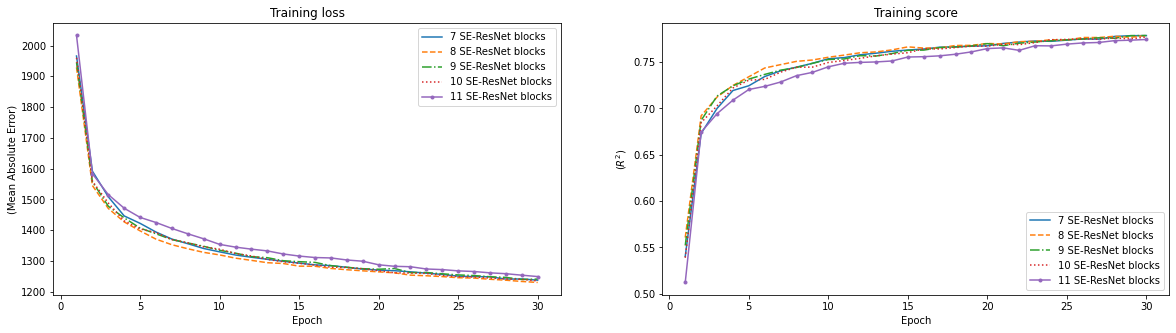

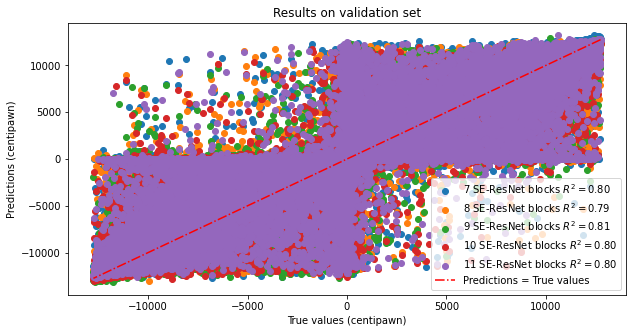

In [8]:
plot_validation_results(histories, positions_valid, scores_valid, path="results/model_selection")

We can see that all of our model perform well.  We pick the one that have the best score.

In [9]:
model, nb_blocks = get_best_model(models, positions_valid, scores_valid)

We save the hyperparameters of our model in order to train it with more data and epochs in the future.

In [10]:
config = {"nb_blocks": nb_blocks, "filters": filters}
print(config)
output_file = open("model/hyperparameters.pickle", "wb")
pickle.dump(config, output_file)
output_file.close()

{'nb_blocks': 9, 'filters': 128}
